In [1]:
import sys
sys.path.append('..')
import jhahn_utils

In [2]:
jhahn_utils.download_file('..','jupyterhub/2024_skin','skin.csv','data')

✅ Found folder 'jupyterhub' (ID: 1p_-DxTEzNFQ-9kzPm3cxNb82iKS5s_zn)
✅ Found folder '2024_skin' (ID: 1CvT81kVEUSrBVdI40-CVShn9Fubogq7u)
📄 Searching for file 'skin.csv' inside 'jupyterhub/2024_skin'...
Found file: 'skin.csv'. Starting download...
Download 100%.

File 'skin.csv' downloaded successfully!


In [5]:
from openpyxl import Workbook
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import itertools
from datetime import datetime
import joblib
from scipy import stats
from sklearn.decomposition import PCA
#from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager as fm

In [6]:
import logging
import os
from datetime import datetime


# 로그 생성
logger = logging.getLogger()

# 로그의 출력 기준 설정
logger.setLevel(logging.INFO)

# log 출력 형식
formatter = logging.Formatter('%(asctime)s[%(levelname)s]: %(message)s')

while logger.hasHandlers():
    logger.removeHandler(logger.handlers[0])
    
    
# log 출력
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


In [7]:
from matplotlib import font_manager
font_manager.findSystemFonts()

['/usr/share/fonts/opentype/malayalam/Gayathri-Thin.otf',
 '/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.ttf',
 '/usr/share/fonts/truetype/padauk/Padauk-Bold.ttf',
 '/usr/share/fonts/truetype/freefont/FreeMonoOblique.ttf',
 '/usr/share/fonts/truetype/fonts-beng-extra/Muktibold.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf',
 '/usr/share/fonts/truetype/tlwg/Garuda-BoldOblique.ttf',
 '/usr/share/fonts/opentype/urw-base35/P052-Italic.otf',
 '/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Bold.ttf',
 '/usr/share/fonts/truetype/teluguvijayam/LakkiReddy.ttf',
 '/usr/share/fonts/truetype/lohit-oriya/Lohit-Odia.ttf',
 '/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',
 '/usr/share/fonts/truetype/tlwg/Laksaman.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf',
 '/usr/share/fonts/truetype/teluguvijayam/ramabhadra.ttf',
 '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',
 '/usr/share/fonts/ope

In [ ]:
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
# rc('font', family=font_name)

In [9]:
filename = "data/skin.csv"

df = pd.read_csv(filename)

/tmp/ipykernel_2495119/197079509.py:3: DtypeWarning: Columns (16,17,18,19,20,21,22,23,25,26,28,29,30,31,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [10]:
# dirty data

df['Sex'] = df['Sex'].replace(' F','F')

In [11]:
print(f"total number of rows:{len(df)}")
print(f"removed rows:{len(df[df.isna().any(axis=1)])}")
df = df[~df.isna().any(axis=1)]

total number of rows:258
removed rows:5


In [12]:
demo_columns = ['Sex','Age']
equip_columns = ['노화기기P','노화기기P','노화기기C','건조기기C','건조기기T','색소기기L','색소기기ITA','유분기기S','민감기기LAST']
biomarker_columns = ['노화바이오마커-A1','노화바이오마커-A2','노화바이오마커-A3','노화바이오마커-A4','건조바이오마커-D1','건조바이오마커-D2','건조바이오마커-D3','건조바이오마커-D4','색소바이오마커-P1','색소바이오마커-P2','색소바이오마커-P3','색소바이오마커-P4','유분바이오마커-O1','유분바이오마커-O2','유분바이오마커-O3','유분바이오마커-O4','민감바이오마커-S1','민감바이오마커-S2','민감바이오마커-S3','민감바이오마커-S4']
dept_columns = ['노화최종판정','건조최종판정','색소최종판정','유분최종판정','민감최종판정']

In [13]:
df = df.drop(columns=equip_columns+biomarker_columns+['No'])


In [14]:
ind_columns = df.columns[7:]
len(ind_columns)

7661

In [12]:
for c in dept_columns+['Sex']:
    df[c] = df[c].astype('category')

for col in df.columns:
    if df.dtypes[col].name == 'category':
        continue
    df[col] = df[col].map(lambda x: float(str(x)[:-1]))
df.dtypes

노화최종판정                           category
건조최종판정                           category
색소최종판정                           category
유분최종판정                           category
민감최종판정                           category
                                   ...   
Sphingobacterium rhinocerotis     float64
Sphingobacterium solani           float64
Weissella bombi                   float64
Weissella minor                   float64
Carnobacterium mobile             float64
Length: 7668, dtype: object

In [13]:
zero_columns = []
for col in df.columns:
    if df.dtypes[col].name != 'category' and df[col].sum() == 0.0:
        zero_columns.append(col)
        
not_normal_columns = []
min_p_value = 0.05
for col in tqdm([c for c in ind_columns if c not in zero_columns]):
    _, _p_value_shapiro = stats.shapiro(df[col].values)
    if _p_value_shapiro < min_p_value:
        not_normal_columns.append(col)

100%|██████████| 7598/7598 [00:00<00:00, 13748.83it/s]


In [14]:
print(f"total:{len(ind_columns)}")
print(f"zero_columns:{len(zero_columns)}")
print(f"not_normal_columns:{len(not_normal_columns)}")

total:7661
zero_columns:63
not_normal_columns:7598


In [15]:
df[ind_columns].sum(axis=1)

0      100.093
1      100.058
2      100.025
3      100.055
4      100.046
        ...   
253     99.930
254    100.014
255    100.040
256    100.046
257    100.013
Length: 253, dtype: float64

In [16]:
_row_list = []
for dept_col in tqdm(dept_columns):
    group1 = df[df[dept_col] == df.dtypes[dept_col].categories[0]]
    group2 = df[df[dept_col] == df.dtypes[dept_col].categories[1]]
    _row = {}
    _row['name'] = f'{dept_col} = {df.dtypes[dept_col].categories[0]}'
    _row['N'] = len(group1)    
    _row['Male/Female'] = f"{(group1['Sex']=='M').sum()} / {(group1['Sex']=='F').sum()}"
    _row['Age(min/mean/max)'] = f"{round(group1['Age'].values.min(),1)} / {round(group1['Age'].values.mean(),1)} / {round(group1['Age'].values.max(),1)}"
    _row_list.append(_row)
    _row = {}
    _row['name'] = f'{dept_col} = {df.dtypes[dept_col].categories[1]}'
    _row['N'] = len(group2)    
    _row['Male/Female'] = f"{(group2['Sex']=='M').sum()} / {(group2['Sex']=='F').sum()}"
    _row['Age(min/mean/max)'] = f"{round(group2['Age'].values.min(),1)} / {round(group2['Age'].values.mean(),1)} / {round(group2['Age'].values.max(),1)}"    
    _row_list.append(_row)
demographic_df = pd.DataFrame(_row_list)
demographic_df.to_csv("output/demographic.csv", index=None)

100%|██████████| 5/5 [00:01<00:00,  4.30it/s]


# ttest

In [18]:
ind_col = 'Sphingobacterium rhinocerotis'
dept_col = '노화최종판정'
min_p_value = 0.05


_row_list = []

for dept_col in tqdm(dept_columns):
    logger.info(dept_col)
    group1 = df[df[dept_col] == df.dtypes[dept_col].categories[0]]
    group2 = df[df[dept_col] == df.dtypes[dept_col].categories[1]]
    
    for ind_col in [c for c in ind_columns if c not in zero_columns]:
        t_stat, p_value = stats.ttest_ind(group1[ind_col], group2[ind_col])

        if np.isnan(p_value):
            continue

        if p_value > min_p_value:
            continue
        
        _row = {}
        _row['dept'] = dept_col
        _row['dept_1'] = df.dtypes[dept_col].categories[0]
        _row['dept_2'] = df.dtypes[dept_col].categories[1]
        _row['ind'] = ind_col
        _row['t_stat'] = t_stat
        _row['pvalue'] = p_value
    
    
        _row_list.append(_row)
    


100%|██████████| 5/5 [01:14<00:00, 15.00s/it]


In [19]:

_ttest_df = pd.DataFrame(_row_list)
_ttest_df.to_csv('output/ttest.csv', encoding='utf-8')

In [20]:
_ttest_sig_count_df = pd.concat([pd.DataFrame(_ttest_df.query('pvalue < 0.01')['dept'].value_counts()),pd.DataFrame(_ttest_df.query('pvalue < 0.05')['dept'].value_counts())],axis=1)
_ttest_sig_count_df.to_csv('output/ttest_count.csv', encoding='utf-8')
_ttest_sig_count_df

,count,count
dept,,
민감최종판정,126,813
노화최종판정,44,420
유분최종판정,41,496
색소최종판정,33,254
건조최종판정,26,167


In [21]:
df.dtypes[dept_col].categories[1]

'Sensitive'

In [22]:
dept_col = '노화최종판정'
_ind_col = 'Lysobacter solisilvae'
group1 = df[df[dept_col] == df.dtypes[dept_col].categories[0]]
group2 = df[df[dept_col] == df.dtypes[dept_col].categories[1]]  

In [23]:
print(dept_col)
print(_ind_col)
print(df.dtypes[dept_col].categories[0])
print(group1[_ind_col].values)
print(df.dtypes[dept_col].categories[1])
print(group2[_ind_col].values)

노화최종판정
Lysobacter solisilvae
Aging
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Tight
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.

 80%|████████  | 4/5 [02:50<00:42, 42.61s/it]


OSError: [Errno 5] Input/output error

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

<Figure size 1000x1500 with 0 Axes>

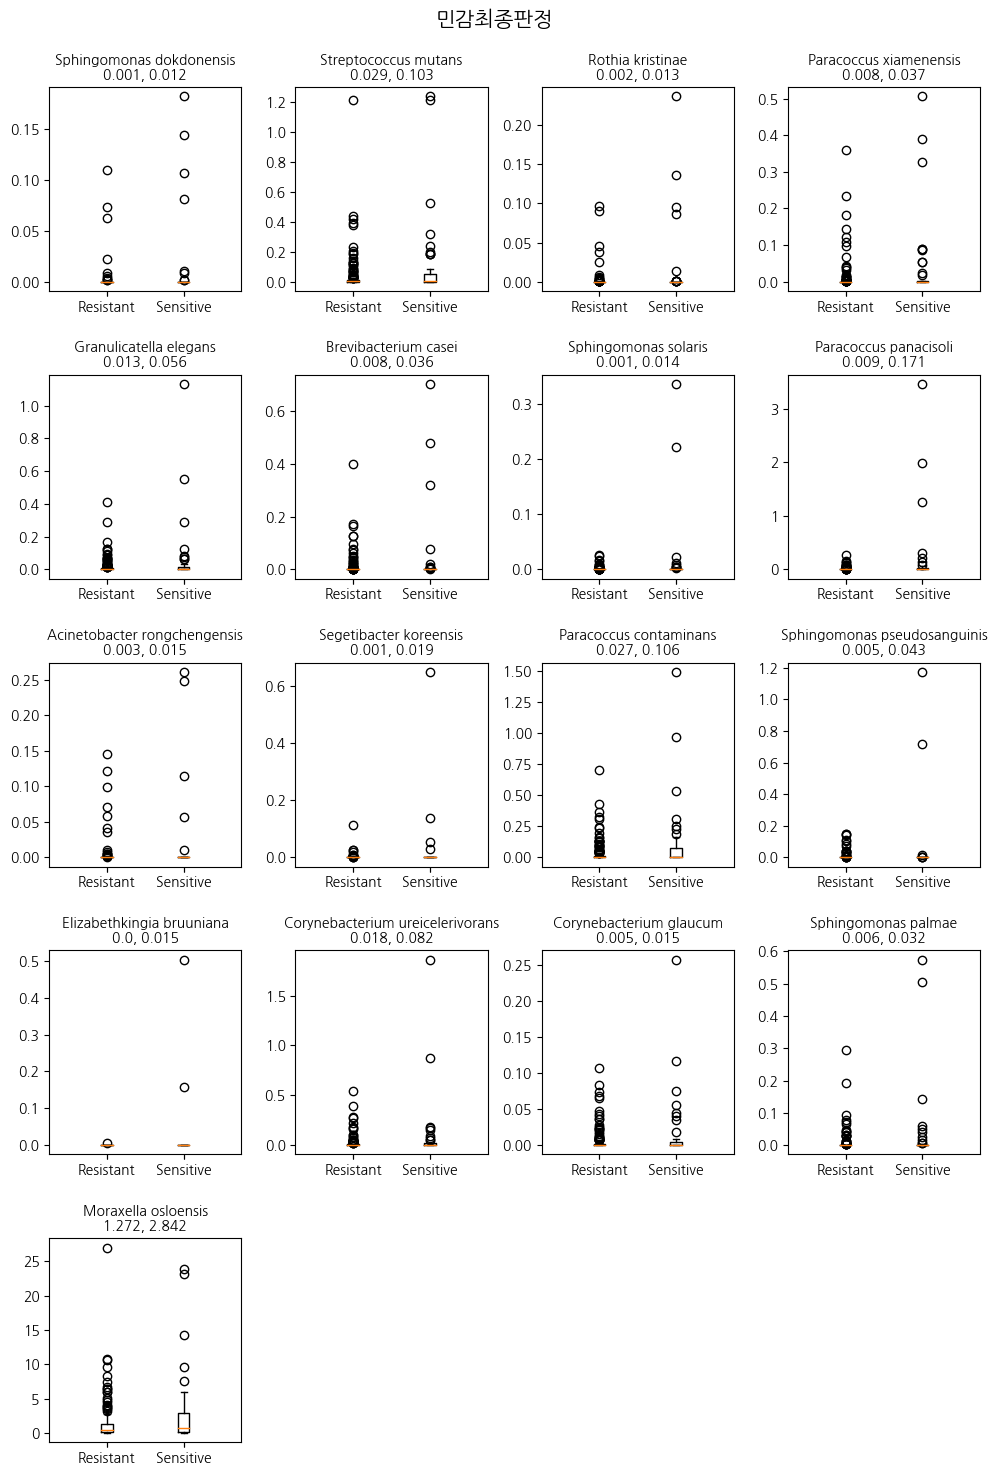

In [25]:
#df.query(f'dept=="{dept_col}"')
dept_col = '노화최종판정'

for dept_col in tqdm(dept_columns):
    logger.info(dept_col)
    plt.clf()
    fig = plt.figure(figsize = (10,15))
    group1 = df[df[dept_col] == df.dtypes[dept_col].categories[0]]
    group2 = df[df[dept_col] == df.dtypes[dept_col].categories[1]]
    
    _x_labels = list(df.dtypes[dept_col].categories)
    _fig_index = 1
    for _ind_col in list(_ttest_df.query(f'pvalue < 0.01 and dept=="{dept_col}"')['ind'].values):
    
        mean_group1 = group1[_ind_col].values.mean()
        mean_group2 = group2[_ind_col].values.mean()
        if abs(mean_group1 - mean_group2) < 0.01:
            continue
        _data = [group1[_ind_col],group2[_ind_col]]
        ax = fig.add_subplot(5,4,_fig_index) 
        ax.set_xticks(np.arange(1, len(_x_labels) + 1), labels=_x_labels)
        ax.set_xlim(0.25, len(_x_labels) + 0.75)
        ax.set_title(f'{_ind_col}\n{round(mean_group1,3)}, {round(mean_group2,3)}', fontsize = 10)
        ax.boxplot(_data, labels=_x_labels)
        
        _fig_index += 1
    
    #plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.5)
    #fig.suptitle(f'{dept_col}\nn={len(group1[_ind_col].values)},{len(group2[_ind_col].values)}', fontsize=15)
    fig.suptitle(f'{dept_col}\n', fontsize=15)
    fig.tight_layout(h_pad=2.0)#reduces the horizontal gap
    #fig.savefig(f'output/box_{dept_col}.pdf', format='pdf', bbox_inches="tight")
    fig.savefig(f'output/box_{dept_col}.png', format='png', bbox_inches="tight")

In [26]:
_ttest_df['dept'].value_counts()

dept
민감최종판정    813
유분최종판정    496
노화최종판정    420
색소최종판정    254
건조최종판정    167
Name: count, dtype: int64

In [27]:
df

,노화최종판정,건조최종판정,색소최종판정,유분최종판정,민감최종판정,Sex,Age,Staphylococcus hominis,Staphylococcus capitis,Staphylococcus massiliensis,...,Sphingoaurantiacus polygranulatus,Sphingobacterium composti Ten et al. 2007 non Yoo et al. 2007,Sphingobacterium corticibacterium,Sphingobacterium haloxyli,Sphingobacterium hotanense,Sphingobacterium rhinocerotis,Sphingobacterium solani,Weissella bombi,Weissella minor,Carnobacterium mobile
0,Tight,Moist,Fair,Oily,Resistant,F,30.0,0.059,0.003,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aging,Moist,Fair,Neutral,Resistant,F,23.0,0.169,0.104,0.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aging,Moist,Fair,Neutral,Resistant,F,50.0,0.690,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aging,Moist,Fair,Neutral,Resistant,F,68.0,0.858,0.001,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tight,Moist,Fair,Neutral,Resistant,F,20.0,0.415,0.832,0.009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Tight,Moist,Fair,Neutral,Resistant,F,49.0,0.296,0.055,0.073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,Tight,Moist,Fair,Neutral,Sensitive,F,62.0,0.540,0.647,0.024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,Aging,Moist,Pigment,Neutral,Resistant,M,22.0,0.071,0.082,0.023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,Tight,Dry,Pigment,Neutral,Sensitive,M,23.0,0.732,4.016,0.096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


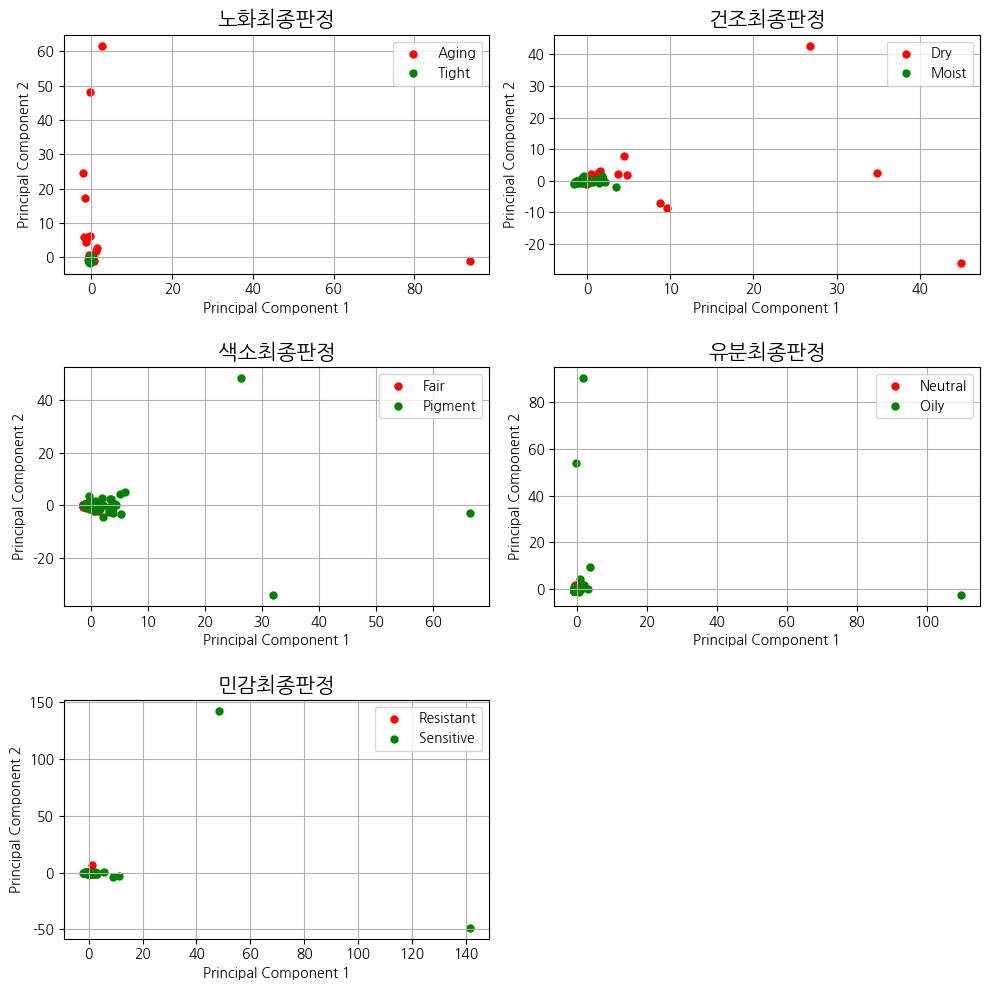

In [26]:

dept_col = '색소최종판정'


fig = plt.figure(figsize = (10,10))
_fig_index = 1

for dept_col in tqdm(dept_columns):
    logger.info(dept_col)
    
    pca = PCA(n_components=2)
        
    _significant_col_list = list(_ttest_df.query(f'pvalue < 0.05 and dept=="{dept_col}"')['ind'].values)
    
    _sig_df = df[_significant_col_list].copy(deep=True)
    _x = StandardScaler().fit_transform(_sig_df)
    #_x = _sig_df
    
    principalComponents = pca.fit_transform(_x)
    
    principalDf = pd.DataFrame(data = principalComponents, index=_sig_df.index
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df[[dept_col]]], axis = 1)
    
    
    
    ax = fig.add_subplot(3,2,_fig_index) 
    ax.set_xlabel('Principal Component 1', fontsize = 10)
    ax.set_ylabel('Principal Component 2', fontsize = 10)
    ax.set_title(dept_col, fontsize = 15)
    
    targets = [df.dtypes[dept_col].categories[0], df.dtypes[dept_col].categories[1]]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[dept_col] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 25)
    ax.legend(targets)
    ax.grid()
    _fig_index += 1
#plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.5)
fig.tight_layout(h_pad=2.0)#reduces the horizontal gap
plt.show()
#fig.savefig(f'output/pca.pdf', format="pdf", bbox_inches="tight")

In [ ]:
pca.explained_variance_ratio_

In [ ]:
df.describe().T

In [ ]:
_base_stat = df[basic_columns].describe().T[['mean','std','min','50%','max']]

basic_columns_stat = df[basic_columns].apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=0).T
basic_columns_stat['95% confidence interval'] = round(basic_columns_stat[0],2).astype(str) + ' - ' + round(basic_columns_stat[1],2).astype(str)
basic_columns_stat = basic_columns_stat[['95% confidence interval']]
basic_columns_stat

_base_stat = pd.concat([_base_stat,basic_columns_stat], axis=1).rename(columns={'mean':'Mean','std':'Standard deviation','50%':'median'}).round(2) 
_base_stat

In [ ]:
df['Sex'].value_counts()

In [ ]:
from scipy.stats import pearsonr


In [ ]:
df[basic_columns].corr(method='pearson')

In [ ]:
rho = df[basic_columns].corr()
pval = df[basic_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

# 회귀분석

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import pandas as pd 
from pandas import MultiIndex, Int16Dtype
import xgboost as xgb
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from tqdm import trange, tqdm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.linear_model import Lasso,ElasticNet,RidgeClassifier
from datetime import datetime
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

In [18]:


# In[40]:


n_jobs = 1
xgb = XGBClassifier(tree_method="gpu_hist", nthread =1,enable_categorical=True )
lgb = LGBMClassifier()
rf = RandomForestClassifier(n_jobs=n_jobs )
svm = SVC()
lreg = LogisticRegression(n_jobs=n_jobs )
ridge = RidgeClassifier( )
lasso = LogisticRegression(n_jobs=n_jobs ,
    penalty='l1',
    solver='saga')
# XGB
param_learning_rate = [0.01,0.1,1.0]
param_iter = [1000,10000,100000]
alpha_set = [0.0001, 0.01, 1]

param_n_estimators =  [100, 500]
param_depth = [5,10]


param_ridge = {"alpha": alpha_set,
               "max_iter": param_iter
              }   
param_lasso = {"C": alpha_set,
               "max_iter": param_iter
              }   
param_rf= {"max_depth": param_depth             ,
              "n_estimators": param_n_estimators
              }    
param_xgb = {"max_depth": param_depth,
             "min_child_weight" : [1,5,10]
             ,
              "n_estimators": param_n_estimators
              }    
# LGB                        
param_lgb = {"learning_rate" : param_learning_rate,
             "max_depth" : param_depth,
             "num_leaves" : [100,500,1000],
             "n_estimators" : param_n_estimators
              }


# SVM
param_svm_c = [0.001, 0.01, 1.0]

param_svm = [
    {'probability':[False],'C': param_svm_c, 
               'kernel': ['linear']}
    ,    
              {'probability':[True],'C': param_svm_c, 
               'gamma': param_svm_c, 
               'kernel': ['rbf']}
     ,
    
              {'probability':[False],'C': param_svm_c, 
               'degree':[2],
               'gamma': param_svm_c, 
               'kernel': ['poly']}
]

# Logistic
param_lreg = { 'C' : [1.0, 5, 10],
              'max_iter': param_iter
              }

scoring = ['accuracy','f1','precision','recall']




In [19]:

scaler_minmax=MinMaxScaler()
scaler_standard=StandardScaler()


In [20]:
ind_cols_aging = ["Staphylococcus hominis","Staphylococcus capitis","Staphylococcus massiliensis","Corynebacterium jeikeium","Cutibacterium acnes","Streptococcus chenjunshii","Staphylococcus saccharolyticus"]
ind_cols_dry = ["Streptococcus caviae","Streptococcus didelphis","Streptococcus iniae","Staphylococcus hominis"]
ind_cols_pigment = ["Streptococcus oralis","Staphylococcus haemolyticus","Corynebacterium tuberculostearicum","Staphylococcus rostri","Staphylococcus muscae","Staphylococcus epidermidis"]
ind_cols_oily = ["Cutibacterium acnes","Streptococcus zalophi","Staphylococcus pasteuri"]
ind_cols_Sensitive = ["Streptococcus mutans","Corynebacterium ureicelerivorans","Actinomyces viscosus","Actinomyces oris","Corynebacterium matruchotii","Streptococcus thermophilus"]
ind_cols_important = ["Cutibacterium acnes","Staphylococcus aureus"]

dep_2_ind_cols = {}

dep_2_ind_cols['노화최종판정'] = ind_cols_aging
dep_2_ind_cols['건조최종판정'] = ind_cols_dry
dep_2_ind_cols['색소최종판정'] = ind_cols_pigment
dep_2_ind_cols['유분최종판정'] = ind_cols_oily
dep_2_ind_cols['민감최종판정'] = ind_cols_Sensitive

ind_cols_all = set()
ind_cols_all.update(ind_cols_important)
for dep in dep_2_ind_cols:
    dep_2_ind_cols[dep] = list(set(dep_2_ind_cols[dep] + ind_cols_important))
    #dep_2_ind_cols[dep] = list(set(dep_2_ind_cols[dep]))
    ind_cols_all.update(dep_2_ind_cols[dep])

ind_cols_all = list(ind_cols_all)
ind_cols_all

_row_list = []
for dep in dep_2_ind_cols:
    _row = {}
    _row['종속변수'] = dep
    _row['독립변수'] = dep_2_ind_cols[dep]

    _row_list.append(_row)

_variables_df = pd.DataFrame(_row_list, index=None)
_variables_df.to_csv('var.csv')
_variables_df

,종속변수,독립변수
0,노화최종판정,"[Corynebacterium jeikeium, Staphylococcus aure..."
1,건조최종판정,"[Streptococcus didelphis, Streptococcus caviae..."
2,색소최종판정,"[Streptococcus oralis, Staphylococcus aureus, ..."
3,유분최종판정,"[Staphylococcus pasteuri, Cutibacterium acnes,..."
4,민감최종판정,"[Actinomyces viscosus, Corynebacterium ureicel..."


In [47]:
X_data = df[df.columns[7:]]
y_data = df[dept_columns]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, shuffle = True)

scaler_minmax.fit(X_train)

#X_train = pd.DataFrame(scaler_minmax.transform(X_train), columns = X_train.columns, index = X_train.index)
#X_test = pd.DataFrame(scaler_minmax.transform(X_test), columns = X_test.columns, index = X_test.index)


MinMaxScaler()

,노화최종판정,건조최종판정,색소최종판정,유분최종판정,민감최종판정,Staphylococcus hominis,Staphylococcus capitis,Staphylococcus massiliensis,Corynebacterium jeikeium,Cutibacterium acnes,...,Sphingoaurantiacus polygranulatus,Sphingobacterium composti Ten et al. 2007 non Yoo et al. 2007,Sphingobacterium corticibacterium,Sphingobacterium haloxyli,Sphingobacterium hotanense,Sphingobacterium rhinocerotis,Sphingobacterium solani,Weissella bombi,Weissella minor,Carnobacterium mobile
0,Tight,Moist,Fair,Oily,Resistant,0.059,0.003,0.002,0.001,31.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aging,Moist,Fair,Neutral,Resistant,0.169,0.104,0.014,0.020,92.262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aging,Moist,Fair,Neutral,Resistant,0.690,0.000,0.000,0.000,77.260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aging,Moist,Fair,Neutral,Resistant,0.858,0.001,0.002,0.021,24.236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tight,Moist,Fair,Neutral,Resistant,0.415,0.832,0.009,0.002,79.378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Tight,Moist,Fair,Neutral,Resistant,0.296,0.055,0.073,0.001,46.140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,Tight,Moist,Fair,Neutral,Sensitive,0.540,0.647,0.024,0.025,83.532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,Aging,Moist,Pigment,Neutral,Resistant,0.071,0.082,0.023,0.005,82.754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,Tight,Dry,Pigment,Neutral,Sensitive,0.732,4.016,0.096,0.017,50.041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2024-12-19 07:37:18,180[INFO]: 노화최종판정
2024-12-19 07:37:45,514[INFO]: 건조최종판정
2024-12-19 07:38:02,903[INFO]: 색소최종판정
2024-12-19 07:38:30,902[INFO]: 유분최종판정
2024-12-19 07:38:40,393[INFO]: 민감최종판정


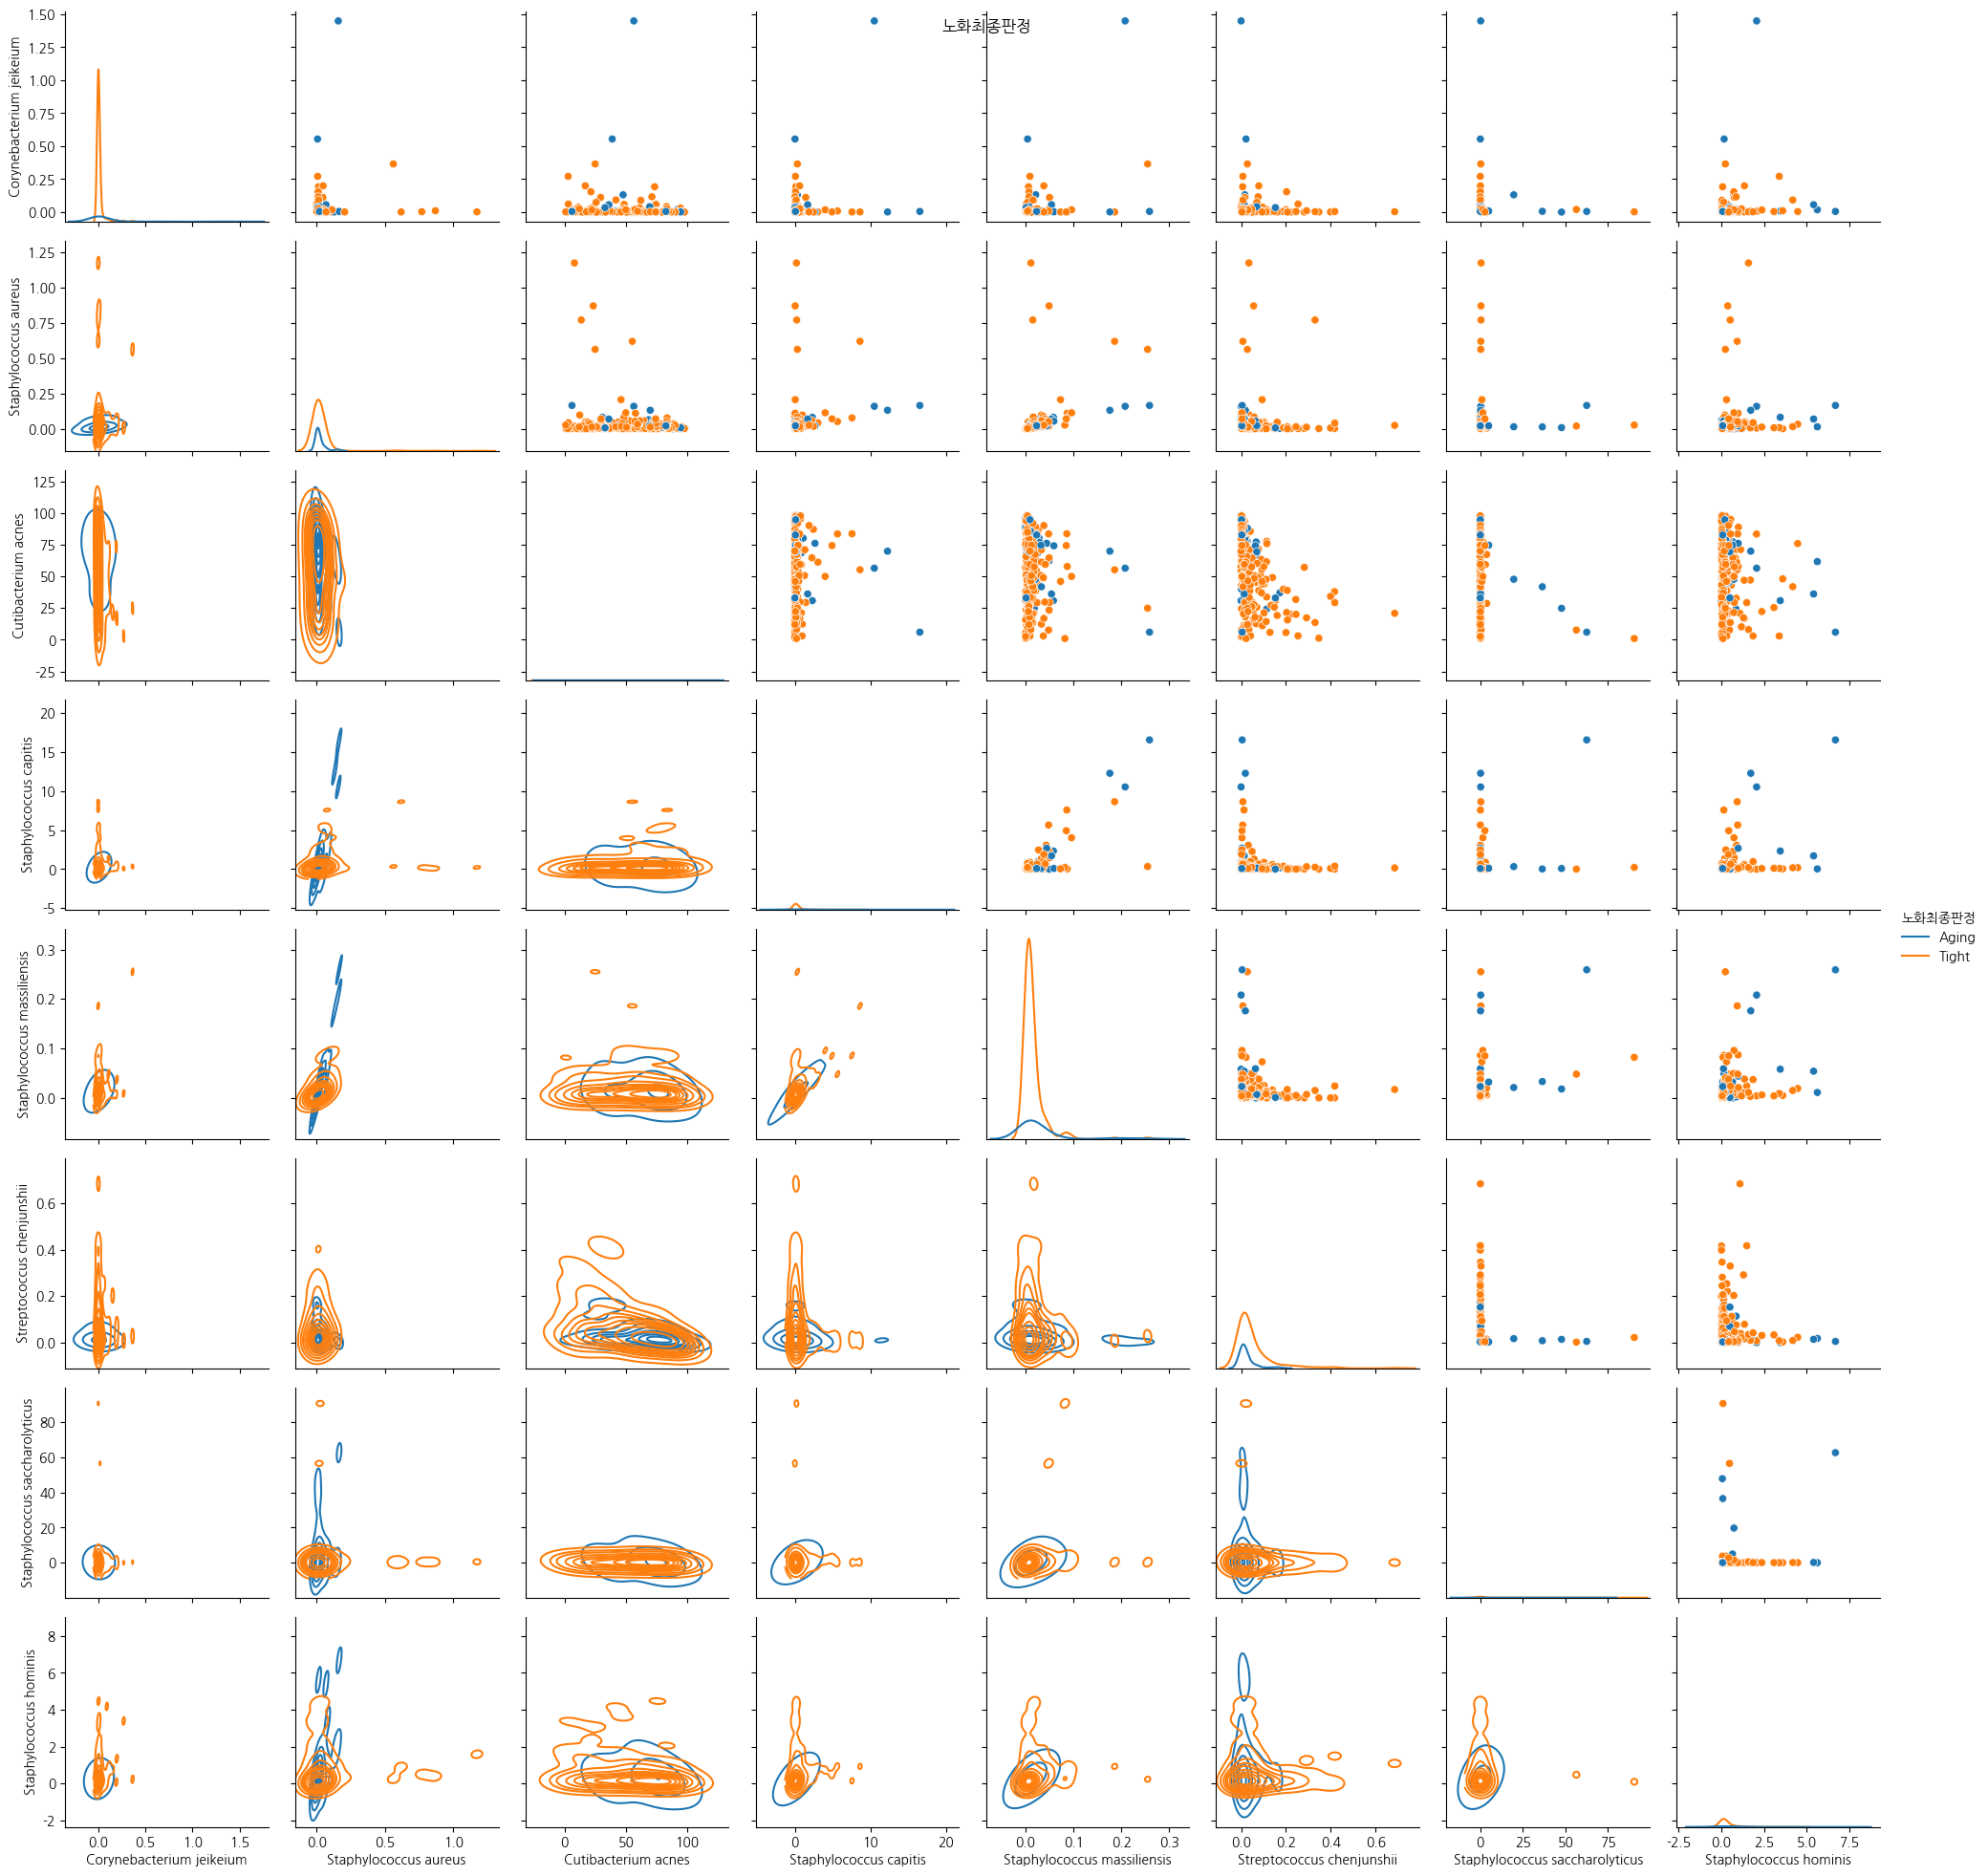

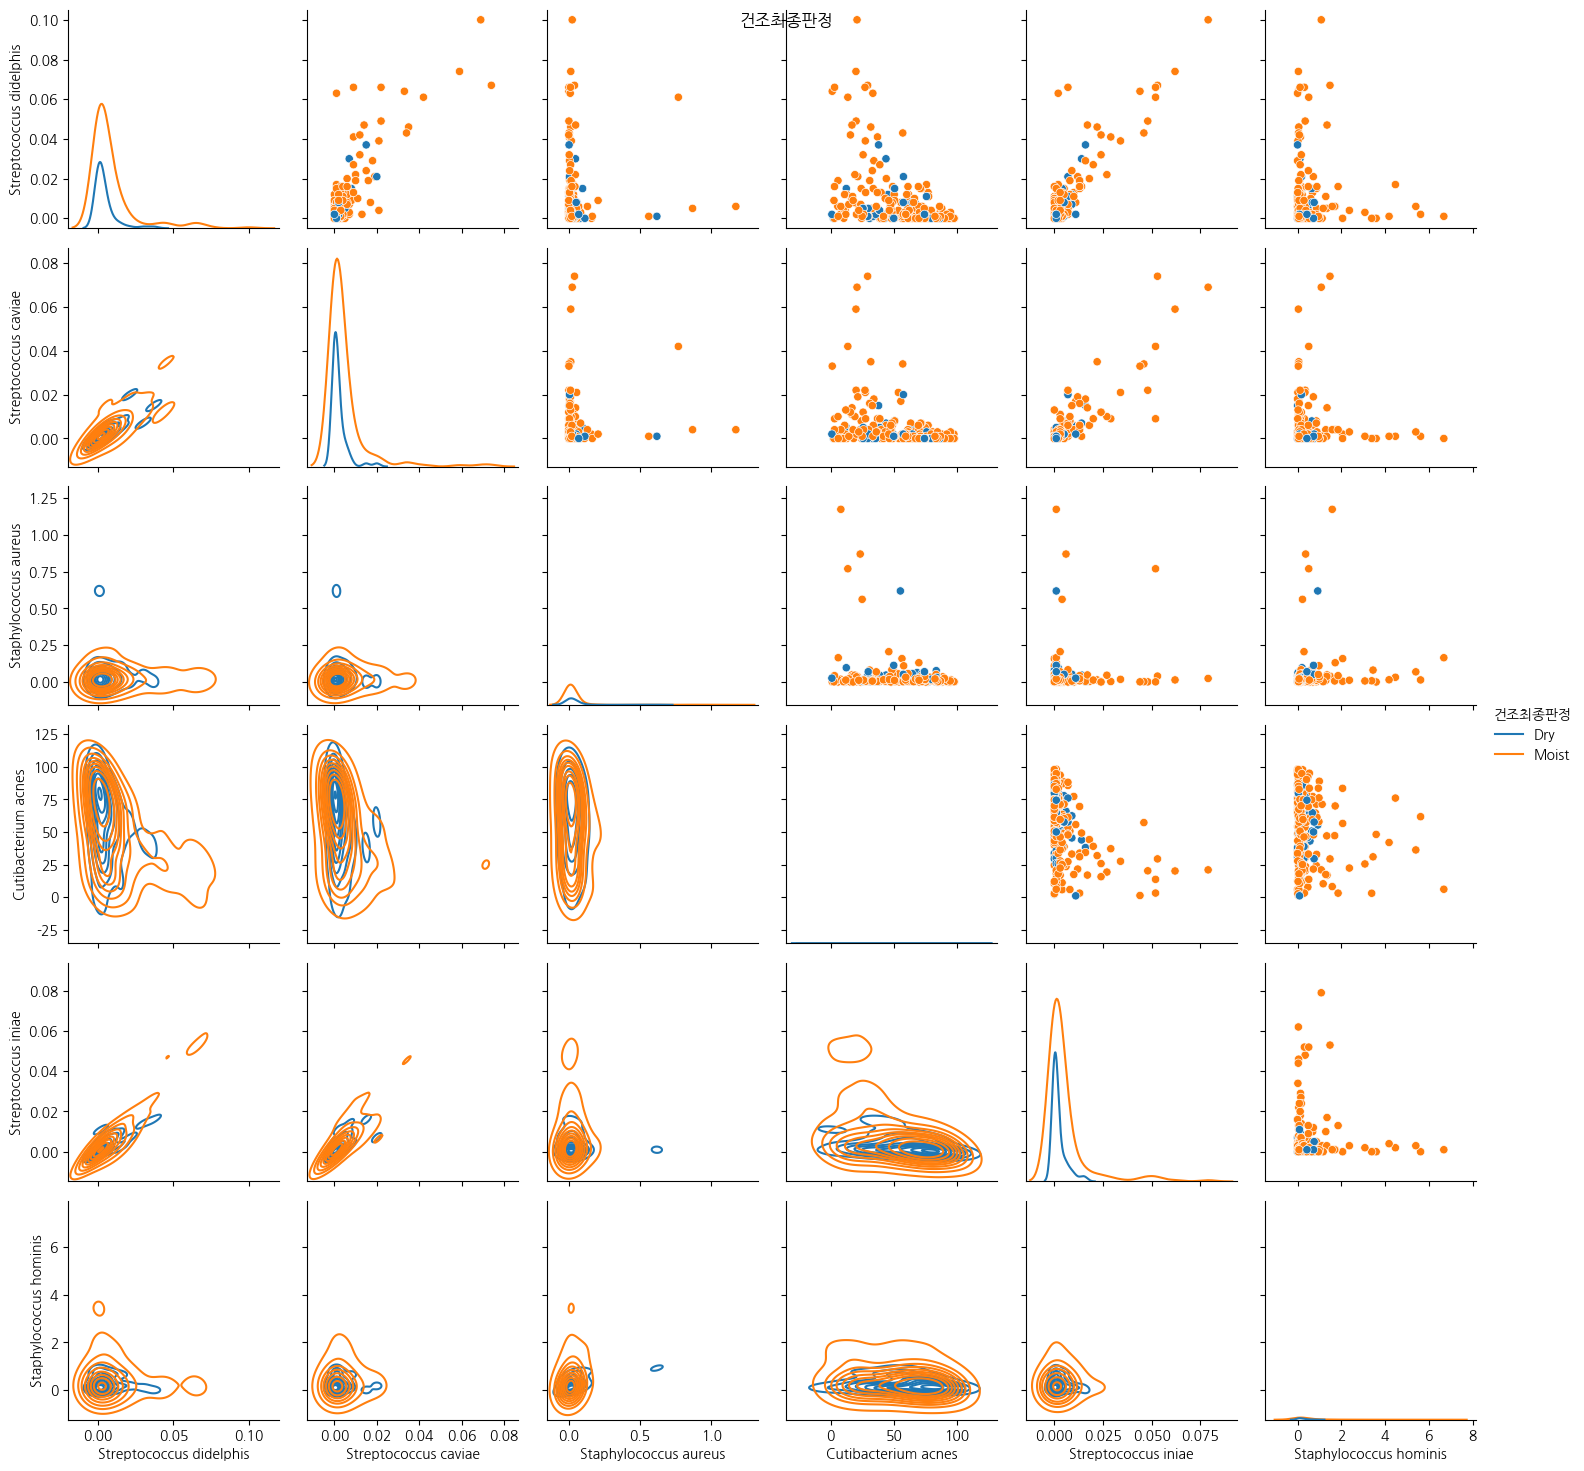

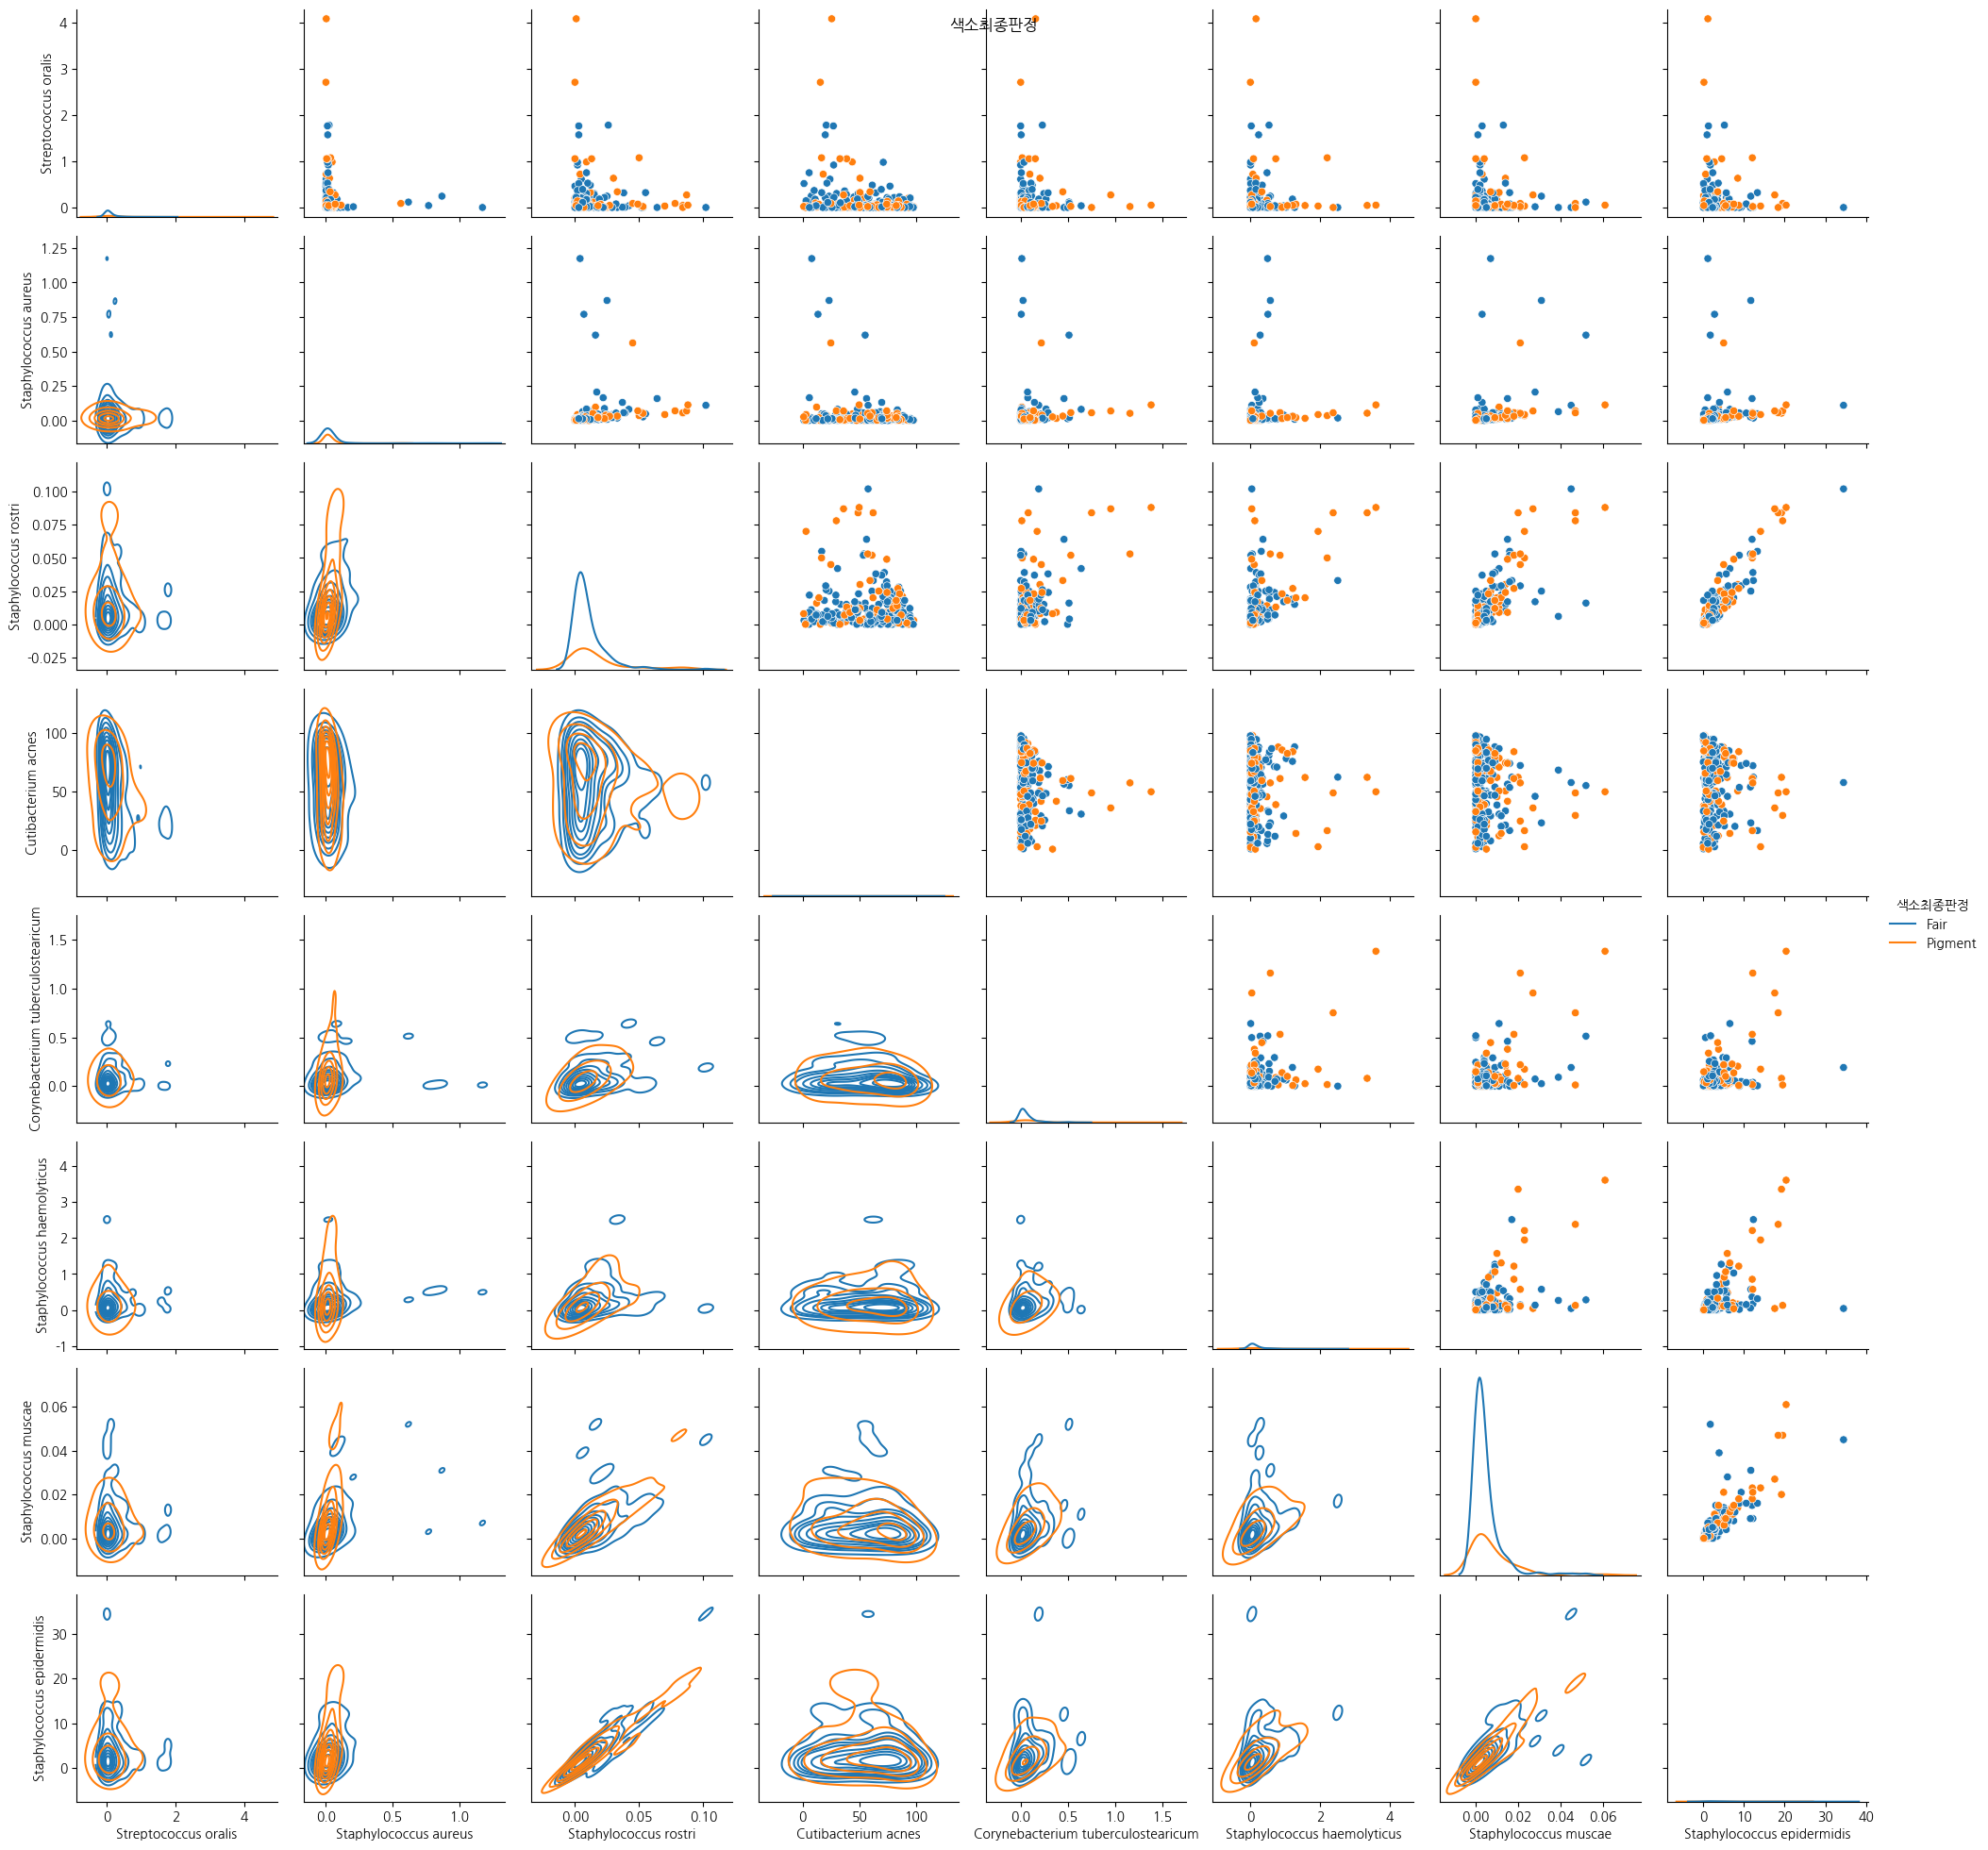

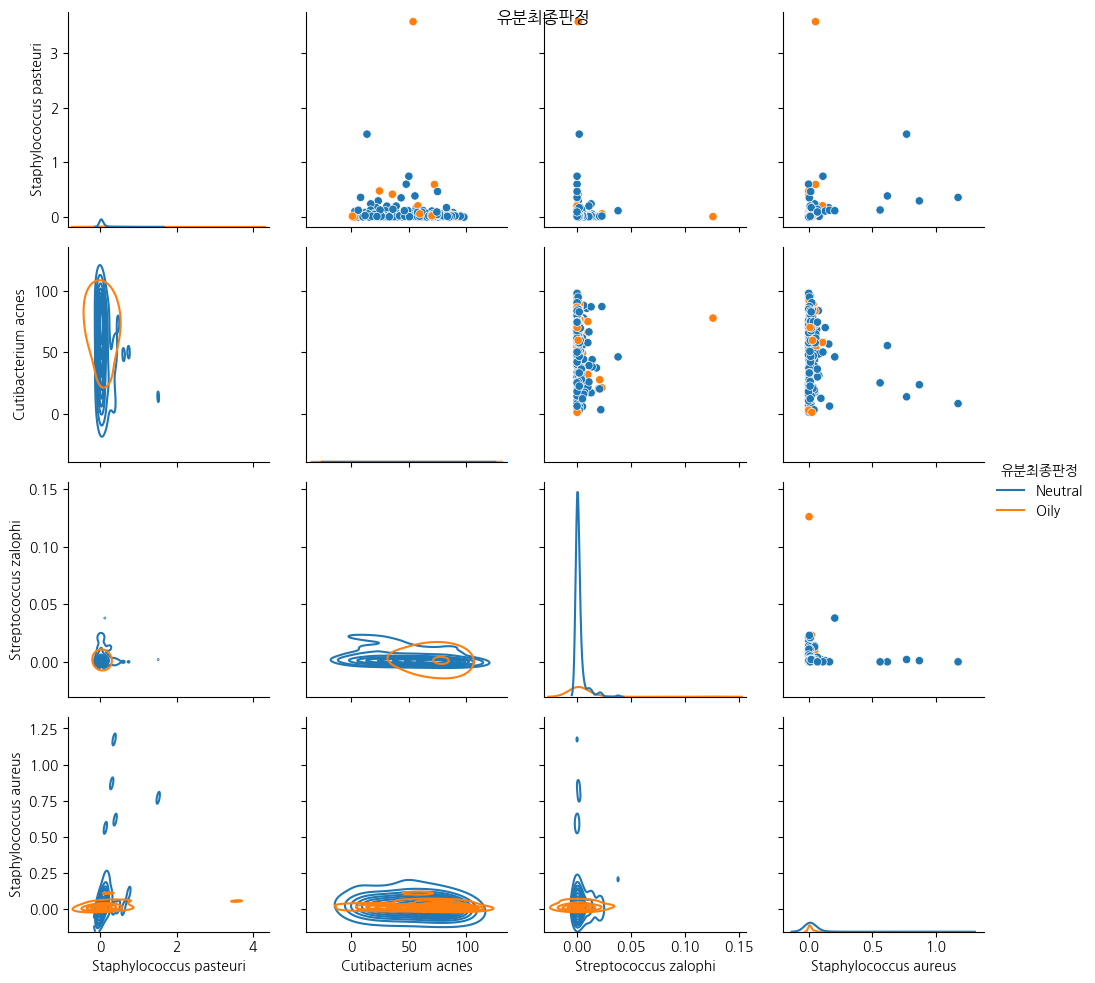

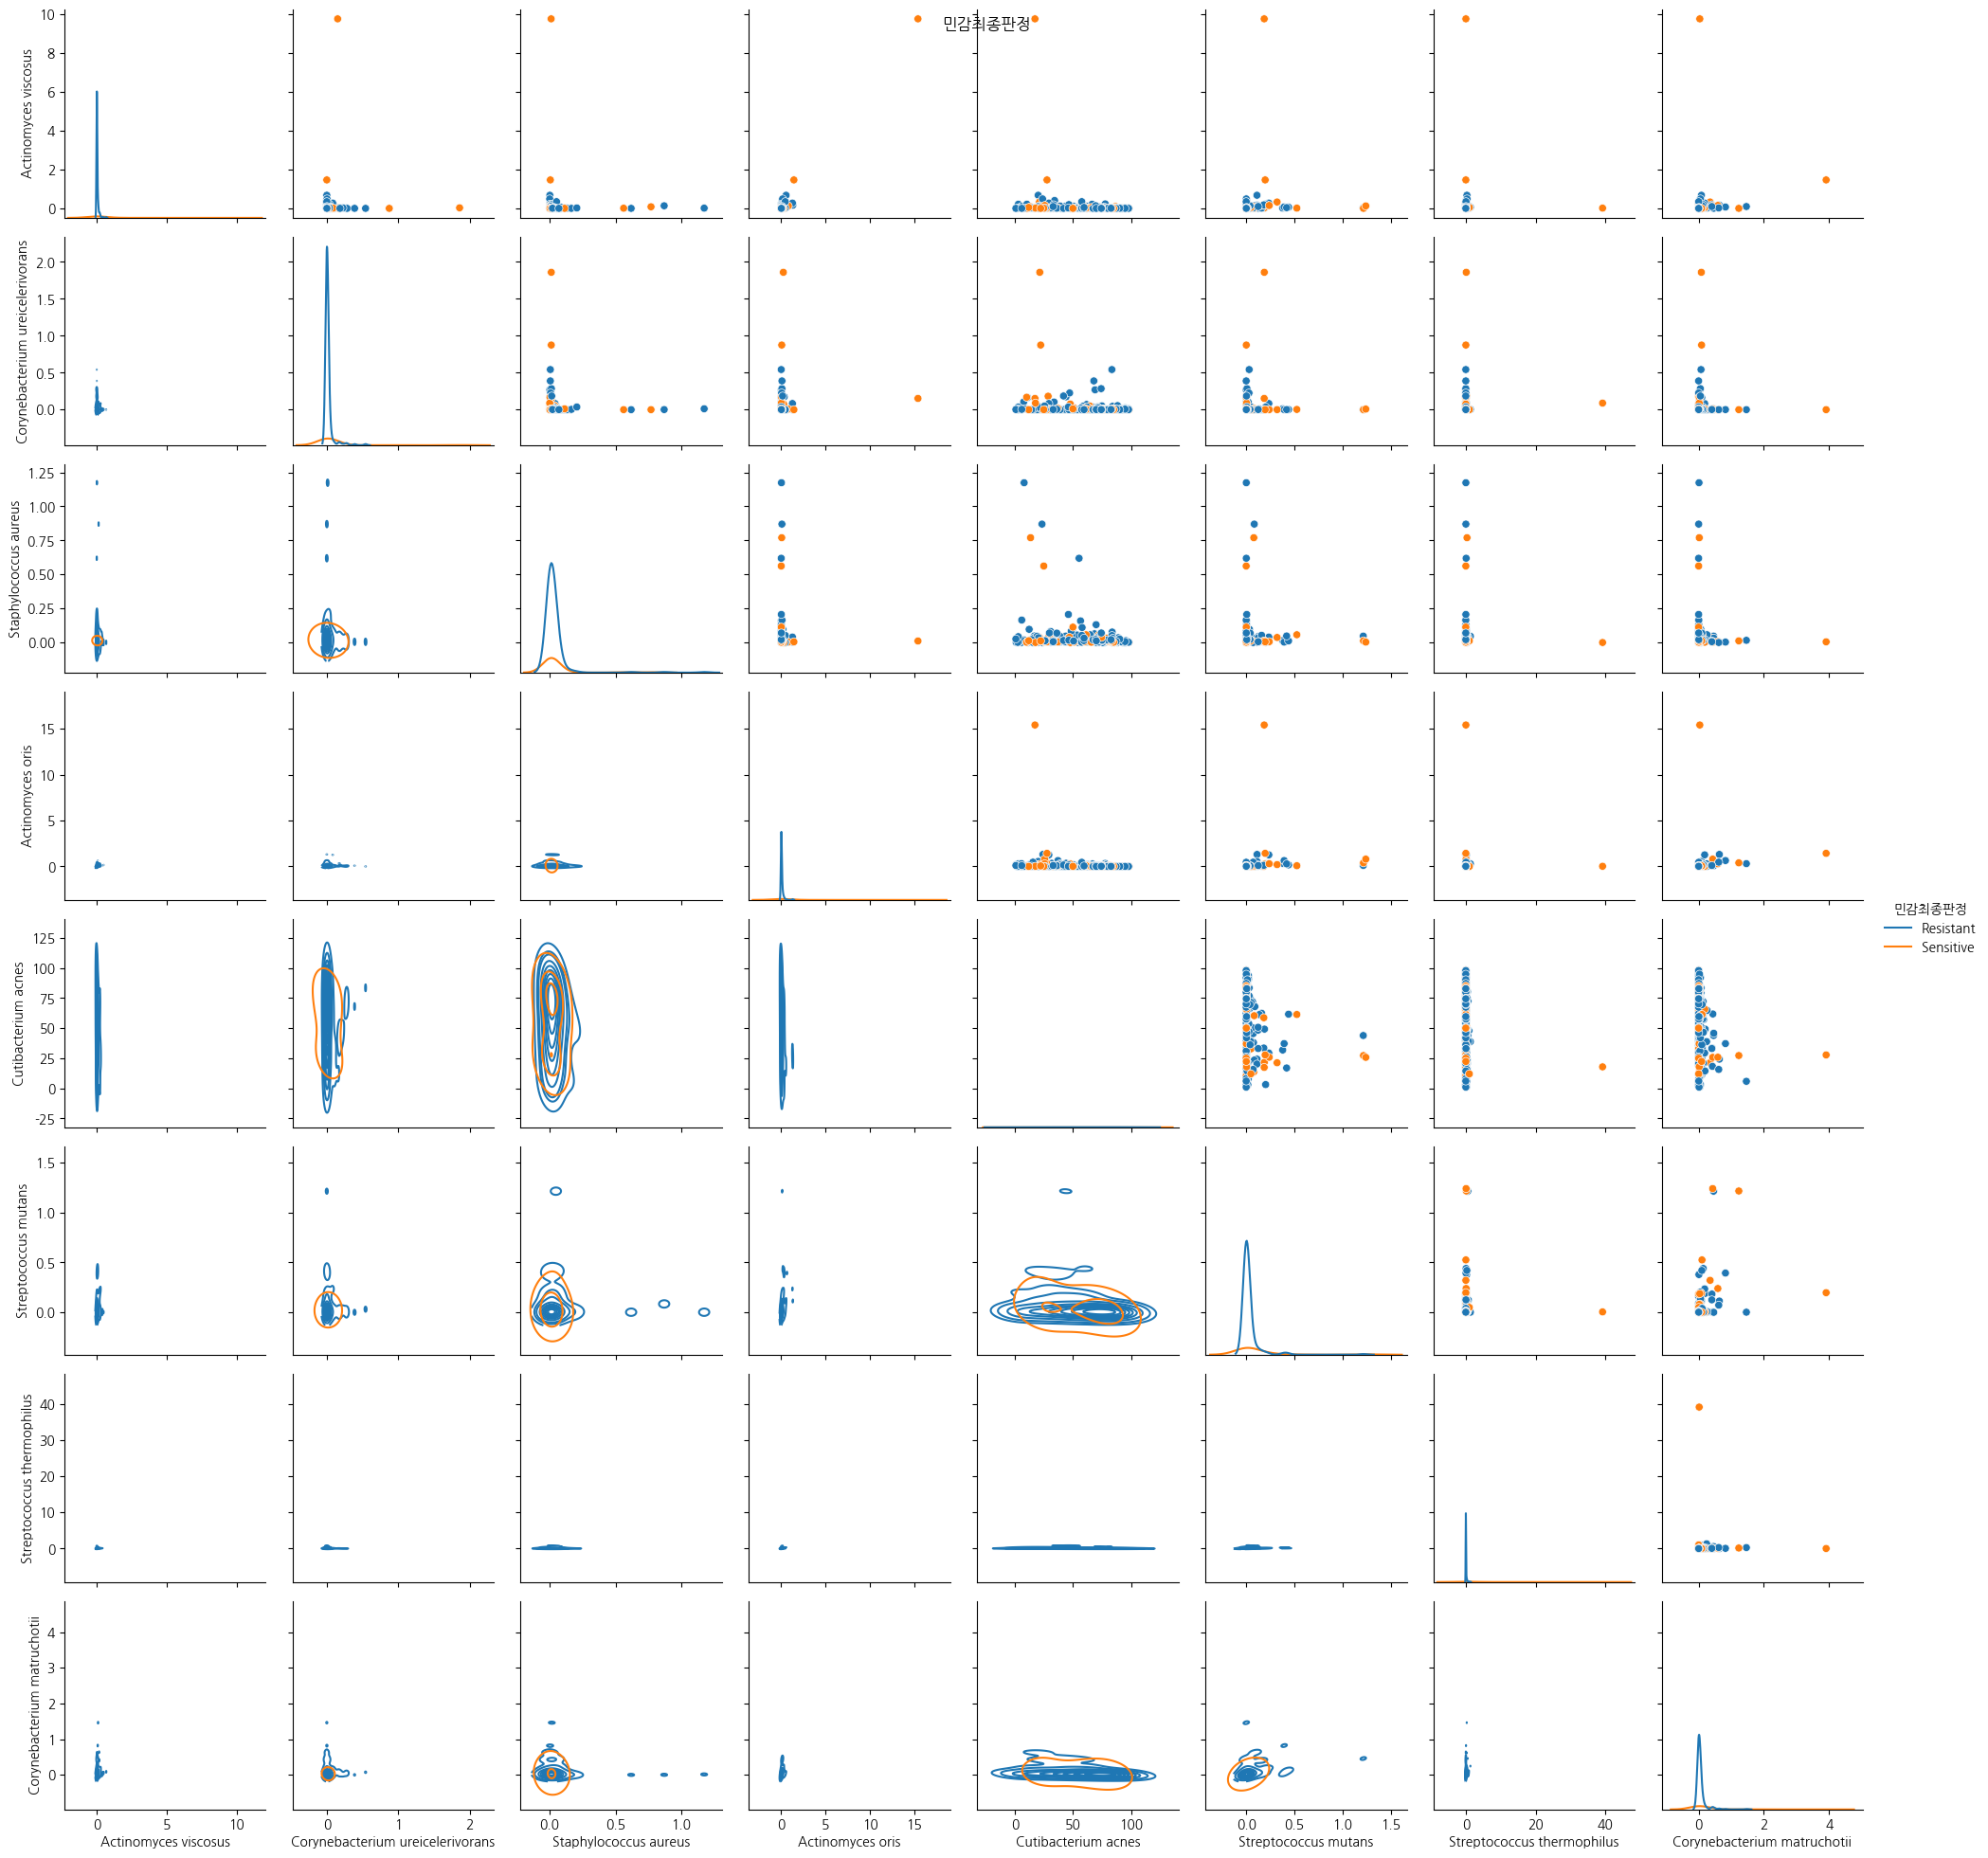

In [22]:
import seaborn as sns
for _dep_var in dep_2_ind_cols:
    logging.info(f'{_dep_var}')
    #_dep_var = '노화최종판정'
    #g = sns.PairGrid(pd.Data, aspect=1.5, diag_sharey=False, despine=False)
    g = sns.PairGrid(pd.concat([y_data[_dep_var],X_data[dep_2_ind_cols[_dep_var]]],axis=1), hue=_dep_var, corner=False, diag_sharey=True)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    g.fig.suptitle(_dep_var)
    g.savefig(f'grid_{_dep_var}.png')


In [23]:
_row_list = []

for d in dept_columns:
    _row = {}
    _row['dep'] = d
    _row['training(80%)'] = f'{y_train[d].value_counts().index[0]} = {y_train[d].value_counts()[0]} / {y_train[d].value_counts().index[1]} = {y_train[d].value_counts()[1]}'
    _row['test(20%)'] = f'{y_test[d].value_counts().index[0]} = {y_test[d].value_counts()[0]} / {y_test[d].value_counts().index[1]} = {y_test[d].value_counts()[1]}'
    _row_list.append(_row)
_count_df = pd.DataFrame(_row_list, index=None)
_count_df.to_csv('count.csv')
_count_df

,dep,training(80%),test(20%)
0,노화최종판정,Tight = 164 / Aging = 38,Tight = 42 / Aging = 9
1,건조최종판정,Moist = 154 / Dry = 48,Moist = 41 / Dry = 10
2,색소최종판정,Fair = 146 / Pigment = 56,Fair = 34 / Pigment = 17
3,유분최종판정,Neutral = 166 / Oily = 36,Neutral = 42 / Oily = 9
4,민감최종판정,Resistant = 168 / Sensitive = 34,Resistant = 40 / Sensitive = 11


NameError: name '_ind_col' is not defined

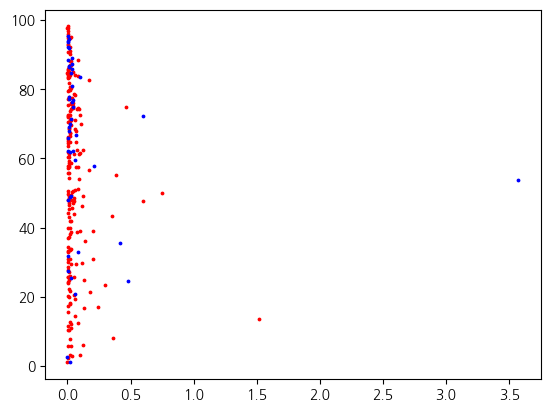

In [26]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

_ind_col_x = 'Staphylococcus pasteuri'
_ind_col_y = 'Cutibacterium acnes'
_dep_var = '유분최종판정'

_y_train = y_data[_dep_var]
_y_train = _y_train.replace(_y_train.cat.categories[0], 0).replace(_y_train.cat.categories[1], 1)

fig, ax = plt.subplots()

_x_train_x = X_data[_ind_col_x]
_x_train_y = X_data[_ind_col_y]

plt.scatter(_x_train_x[_y_train == 0], _x_train_y[_y_train == 0], s=3, c='r', label=y_data[_dep_var].cat.categories[0])
plt.scatter(_x_train_x[_y_train == 1], _x_train_y[_y_train == 1], s=3, c='b', label=y_data[_dep_var].cat.categories[1])

#plt.scatter(X_data[_ind_col][y==0], X_data[_ind_col][y==0], s=3, c='r')
#plt.scatter(X_data[_ind_col][y==1], X_data[_ind_col][y==1], s=3, c='b')


logreg = sm.Logit(_y_train, sm.add_constant(X_data[_ind_col])).fit()
pred_3 = logreg.predict(sm.add_constant(X_data[_ind_col])) 







#ax.plot(X_data[_ind_col], pred_3, "o", label="Pred")
#ax.plot(X_data[_ind_col], _y_train, "o", label="True")
#ax.plot(np.hstack((x1, x1n)), np.hstack((ypred, ynewpred)), "r", label="OLS prediction")
ax.legend(loc="best")

In [68]:
dep_var = '노화최종판정'
auc_max = 0.0
X_train_max, X_test_max, y_train_max, y_test_max = None, None, None, None

for i in tqdm(range(200)):
    X_data = df[df.columns[7:]]
    y_data = df[dept_columns]
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, shuffle = True)
    
    scaler_minmax.fit(X_train)
    
    #logging.info(f'{dep_var}')
    _ind_columns = dep_2_ind_cols[dep_var]
    #_ind_columns = ind_cols_important
    #_ind_columns = ind_cols_all
    
    #X_data, y_data
    
    _y_train = y_train[dep_var]
    _y_train = _y_train.replace(_y_train.cat.categories[0], 0).replace(_y_train.cat.categories[1], 1)
    
    _X_train = X_train[_ind_columns]
    
    _y_test = y_test[dep_var]
    _y_test = _y_test.replace(_y_test.cat.categories[0], 0).replace(_y_test.cat.categories[1], 1)    
    _X_test = X_test[_ind_columns]
    
    #plt.clf()
    
    #logreg = sm.OLS(_y_train, sm.add_constant(_X_train)).fit_regularized(alpha=0.9, L1_wt=0.1)
    logreg = sm.Logit(_y_train, sm.add_constant(_X_train)).fit()
    #print(logreg.summary2())
    
    result_map[dep_var] = {}
    result_map[dep_var]['model'] = logreg
    
    pred_3 = logreg.predict(sm.add_constant(_X_test)) 
    
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(_y_test, pred_3,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    if auc_max < roc_auc:
        auc_max = roc_auc
        X_train_max, X_test_max, y_train_max, y_test_max = X_train, X_test, y_train, y_test
        logging.info(f'{roc_auc}')
#X_train = pd.DataFrame(scaler_minmax.transform(X_train), columns = X_train.columns, index = X_train.index)
#X_test = pd.DataFrame(scaler_minmax.transform(X_test), columns = X_test.columns, index = X_test.index)
    

2024-12-19 10:26:47,749[INFO]: 0.8506493506493507


Optimization terminated successfully.
         Current function value: 0.456359
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.438982
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.418306
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416820
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.419352
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.463882
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.459183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.440444
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435073
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.43271

2024-12-19 10:27:06,738[INFO]: 0.9338624338624338


Optimization terminated successfully.
         Current function value: 0.450801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.395221
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.437150
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.438368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.389039
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.426364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.426911
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.425821
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.439205
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.4036

In [69]:
X_train_max.to_csv("x_train.csv")
X_test_max.to_csv("X_test.csv")
y_train_max.to_csv("y_train.csv")
y_test_max.to_csv("y_test.csv")

2024-12-19 10:30:29,037[INFO]: 노화최종판정


Optimization terminated successfully.
         Current function value: 0.450801
         Iterations 10
const가 1단위 증가할 때, 노화최종판정이 Tight일 확률이 그렇지 않을 경우보다 11.957배 증가한다.


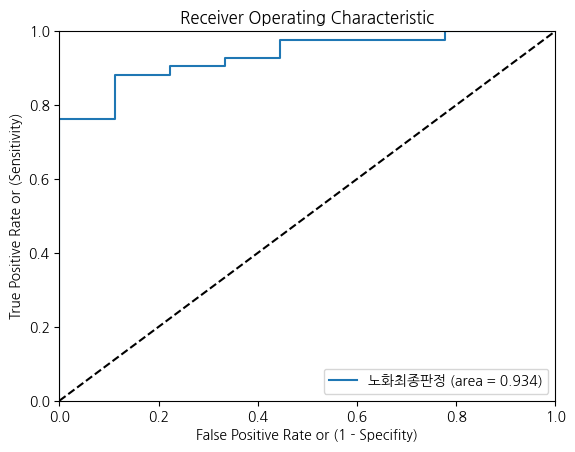

In [72]:
result_map = {}
X_train, X_test, y_train, y_test = X_train_max, X_test_max, y_train_max, y_test_max
fig = plt.figure()
for dep_var in dep_2_ind_cols:
    if not '노화최종판정' == dep_var:
        continue
    
    logging.info(f'{dep_var}')
    _ind_columns = dep_2_ind_cols[dep_var]
    #_ind_columns = ind_cols_important
    #_ind_columns = ind_cols_all
    
    #X_data, y_data
    
    _y_train = y_train[dep_var]
    _y_train = _y_train.replace(_y_train.cat.categories[0], 0).replace(_y_train.cat.categories[1], 1)

    _X_train = X_train[_ind_columns]

    _y_test = y_test[dep_var]
    _y_test = _y_test.replace(_y_test.cat.categories[0], 0).replace(_y_test.cat.categories[1], 1)    
    _X_test = X_test[_ind_columns]
    
    #plt.clf()

    #logreg = sm.OLS(_y_train, sm.add_constant(_X_train)).fit_regularized(alpha=0.9, L1_wt=0.1)
    logreg = sm.Logit(_y_train, sm.add_constant(_X_train)).fit()
    #print(logreg.summary2())

    result_map[dep_var] = {}
    result_map[dep_var]['model'] = logreg
    
    pred_3 = logreg.predict(sm.add_constant(_X_test)) 
    
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(_y_test, pred_3,pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    
    plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (dep_var, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")


    _summary_df = pd.read_html(logreg.summary().tables[1].as_html(),header=0,index_col=0)[0]
    _summary_df['exp'] = np.exp(_summary_df['coef'])
    for _v, row in _summary_df.iterrows():
        if row['P>|z|'] <= 0.05:
            print(f'{_v}가 1단위 증가할 때, {dep_var}이 {df[dep_var].cat.categories[1]}일 확률이 그렇지 않을 경우보다{row["exp"] : .3f}배 증가한다.')
    
    #prediction_3 = list(map(round, pred_3))
    #prediction_3 = []
    #for _w in pred_3:
        #if _w > logreg.params[0]:
    #    if _w > 0.5:
    #        prediction_3.append(1)
    #    else:
    #        prediction_3.append(0)
    
    #print(pd.concat([pd.DataFrame(_y_test),pd.DataFrame(pred_3, index=_y_test.index),pd.DataFrame(prediction_3, index=_y_test.index)],axis=1))

    
    #_f1 = f1_score(_y_test, prediction_3, pos_label='positive', average='micro')
    #_cm = confusion_matrix(_y_test, prediction_3) 
    #print(_f1)
    #print(_cm)
    #result_map[dep_var]['f1'] = _f1
    #result_map[dep_var]['cm'] = _cm
    #if True:
    #    break
#print(result_map)
fig.savefig('roc.pdf')
result_map = {k: v for k, v in sorted(result_map.items(), key=lambda x: x[0])}
model_list = []
for k in result_map:
    model_list.append(result_map[k]['model'])


In [480]:
#https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults

out_table = summary_col(
    model_list,
    include_r2=True,
    stars=True, 
    float_format='%.2f',
    info_dict={
        'N':lambda x: "{0:d}".format(int(x.nobs)),
        #'R2':lambda x: "{0:d}".format(x.rsquared),
        'Log-likelihood':lambda x: "{:.2f}".format(x.llf)
    }
)
out_table

,건조최종판정,노화최종판정,민감최종판정,색소최종판정,유분최종판정
Actinomyces oris,,,-2.00,,
,,,(1.98),,
Actinomyces viscosus,,,3.87,,
,,,(2.84),,
Corynebacterium jeikeium,,-2.78,,,
,,(3.71),,,
Corynebacterium matruchotii,,,0.56,,
,,,(1.08),,
Corynebacterium tuberculostearicum,,,,2.21,
,,,,(1.50),


In [481]:
results_text = out_table.as_html()

import csv
resultFile = open("summary.html",'w')
resultFile.write(results_text)
resultFile.close()

# 기계학습

In [384]:
result_map = {}
_model_list = [('svm',svm,param_svm,'m'),('ridge',ridge,param_ridge,'b'),('rf',rf,param_rf,'g'),('lasso',lasso,param_lasso,'r')]
result_df_list = []

scaler = ('MinMaxScaler', MinMaxScaler())
for dep_var in dep_2_ind_cols:
    
    logging.info(f'{dep_var}')
    _ind_columns = dep_2_ind_cols[dep_var]
    #_ind_columns = ind_cols_important
    #X_data, y_data
    
    _y_train = y_data[dep_var]
    _y_train = _y_train.replace(_y_train.cat.categories[0], 0).replace(_y_train.cat.categories[1], 1)

    _X_train = X_data[_ind_columns]

    #_y_test = y_test[dep_var]
    #_y_test = _y_test.replace(_y_test.cat.categories[0], 0).replace(_y_test.cat.categories[1], 1)    
    #_X_test = X_test[_ind_columns]
    plt.clf()

    for model_name,m, p, _c in _model_list:
        logging.info(f'{model_name}')
        _params = None
        if type(p) == list:
            _params = []
            for param_items in p:
                _params.append({ model_name+"__"+k: v for k, v in param_items.items() })
        else:
            _params = { model_name+"__"+k: v for k, v in p.items() }


        pipe = Pipeline([scaler, (model_name,m)])
            
        _gscv = GridSearchCV (pipe, param_grid = _params, scoring ='f1', cv = 5, refit=True, n_jobs=1, verbose=0)
        _gscv.fit(_X_train, _y_train)
        _gscv_result_df = pd.DataFrame.from_dict(data=_gscv.cv_results_, orient='columns')
        _gscv_result_df['dep_var'] = dep_var
        result_df_list.append(_gscv_result_df)
        #print(_gscv_result_df)
        if True:
            continue
        #logreg = sm.OLS(_y_train, sm.add_constant(_X_train)).fit_regularized(alpha=0.9, L1_wt=0.1)
        logreg = sm.Logit(_y_train, sm.add_constant(_X_train)).fit()
        #print(logreg.summary2())
    
        result_map[dep_var] = {}
        result_map[dep_var]['model'] = logreg
        
        #print(list(_y_test.values))
        pred_3 = logreg.predict(sm.add_constant(_X_test)) 
        #print(pred_3)
        
    
        
        # Compute fpr, tpr, thresholds and roc auc
        fpr, tpr, thresholds = roc_curve(_y_test, pred_3,pos_label = 1)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        
        plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (dep_var, roc_auc))
        plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate or (1 - Specifity)')
        plt.ylabel('True Positive Rate or (Sensitivity)')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
    

    #prediction_3 = list(map(round, pred_3))
    #prediction_3 = []
    #for _w in pred_3:
        #if _w > logreg.params[0]:
    #    if _w > 0.5:
    #        prediction_3.append(1)
    #    else:
    #        prediction_3.append(0)
    
    #print(pd.concat([pd.DataFrame(_y_test),pd.DataFrame(pred_3, index=_y_test.index),pd.DataFrame(prediction_3, index=_y_test.index)],axis=1))

    
    #_f1 = f1_score(_y_test, prediction_3, pos_label='positive', average='micro')
    #_cm = confusion_matrix(_y_test, prediction_3) 
    #print(_f1)
    #print(_cm)
    #result_map[dep_var]['f1'] = _f1
    #result_map[dep_var]['cm'] = _cm
    #if True:
    #    break
print(result_map)

result_map = {k: v for k, v in sorted(result_map.items(), key=lambda x: x[0])}
model_list = []
for k in result_map:
    model_list.append(result_map[k]['model'])

2024-11-12 15:50:28,116[INFO]: 노화최종판정
2024-11-12 15:50:28,127[INFO]: svm
2024-11-12 15:50:29,192[INFO]: ridge
2024-11-12 15:50:29,528[INFO]: rf
2024-11-12 15:50:37,960[INFO]: lasso
2024-11-12 15:50:38,293[INFO]: 건조최종판정
2024-11-12 15:50:38,296[INFO]: svm
2024-11-12 15:50:39,185[INFO]: ridge
2024-11-12 15:50:39,522[INFO]: rf
2024-11-12 15:50:47,828[INFO]: lasso
2024-11-12 15:50:48,161[INFO]: 색소최종판정
2024-11-12 15:50:48,164[INFO]: svm
2024-11-12 15:50:49,135[INFO]: ridge
2024-11-12 15:50:49,473[INFO]: rf
2024-11-12 15:50:58,011[INFO]: lasso
2024-11-12 15:50:58,348[INFO]: 유분최종판정
2024-11-12 15:50:58,351[INFO]: svm
2024-11-12 15:50:59,169[INFO]: ridge
2024-11-12 15:50:59,491[INFO]: rf
2024-11-12 15:51:07,867[INFO]: lasso
2024-11-12 15:51:08,168[INFO]: 민감최종판정
2024-11-12 15:51:08,171[INFO]: svm
2024-11-12 15:51:09,054[INFO]: ridge
2024-11-12 15:51:09,390[INFO]: rf
2024-11-12 15:51:17,754[INFO]: lasso


{}


<Figure size 640x480 with 0 Axes>

In [385]:
pd.concat(result_df_list,axis=0).to_csv('cv.csv')

,건조최종판정,노화최종판정,민감최종판정,색소최종판정,유분최종판정
Actinomyces oris,,,-2.18,,
,,,(2.13),,
Actinomyces viscosus,,,0.54,,
,,,(1.53),,
Corynebacterium jeikeium,,-6.07,,,
,,(4.47),,,
Corynebacterium matruchotii,,,-0.71,,
,,,(3.25),,
Corynebacterium tuberculostearicum,,,,2.35,
,,,,(1.91),


In [ ]:
pd.DataFrame(X_train).describe()

In [ ]:
pd.DataFrame(X_scaled_minmax_train).describe()

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()


In [49]:
predicted = logr.predict(X_test)
logr.score(X_test, y_test)

0.7843137254901961

In [191]:
import statsmodels.api as sm

logreg = sm.Logit(y_train, sm.add_constant(X_scaled_minmax_train)).fit()
print(logreg.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).